In [1]:
import rerun as rr

In [2]:
EXAMPLE_FOLDER = "/deepstore/datasets/dmb/ComputerVision/information_retrieval/AriaEA/loc1_script1_seq1_rec1"
EYE_GAZE = f"{EXAMPLE_FOLDER}/mps/eye_gaze/general_eye_gaze.csv"
vrs_file_path = f"{EXAMPLE_FOLDER}/recording.vrs"
SPEECH = f"{EXAMPLE_FOLDER}/speech.csv"

In [3]:
from projectaria_tools.core import data_provider

vrs_data_provider = data_provider.create_vrs_data_provider(vrs_file_path)

[ProgressLogger][INFO]: 2025-11-20 18:28:24: Opening /deepstore/datasets/dmb/ComputerVision/information_retrieval/AriaEA/loc1_script1_seq1_rec1/recording.vrs...
[MultiRecordFileReader][DEBUG]: Opened file '/deepstore/datasets/dmb/ComputerVision/information_retrieval/AriaEA/loc1_script1_seq1_rec1/recording.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 211-1/camera-et activated
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated
[VrsDataProvider][INFO]: streamId 231-1/mic activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][INFO]: streamId 1201-1/camera-slam-left activated
[VrsDataProvider][INFO]: streamId 1201-2/camera-slam-right activated
[VrsDataProvider][INFO]: streamId 1202-1/imu-right activated
[VrsDataProvider][INFO]: streamId 1202-2/imu-left activated
[VrsDataProvider][INFO]: streamId 1203-1/mag0 activated


# Tutorial 1: VrsDataProvider Basics

In [ ]:
# Get all available streams
all_streams = vrs_data_provider.get_all_streams()
print(f"Found {len(all_streams)} streams in the VRS file:")
    
# Print out each stream id, and their corresponding sensor label
for stream_id in all_streams:
    label = vrs_data_provider.get_label_from_stream_id(stream_id)
    print(f" --- Data stream {stream_id}'s label is: {label}")

In [ ]:
# Find a specific stream's StreamId by sensor label
print("Seeking RGB data stream...")
rgb_stream_id = vrs_data_provider.get_stream_id_from_label("camera-rgb")
if rgb_stream_id is not None:
    print(f"Found camera-rgb stream in VRS file: {rgb_stream_id}")
else:
    print("Cannot find camera-rgb stream in VRS file.")

In [ ]:
# Visualize with Rerun
import rerun as rr
rr.init("rerun_viz_query_by_index")

# Get number of samples in stream
num_samples = vrs_data_provider.get_num_data(rgb_stream_id)
print(f"RGB stream has a total of {num_samples} frames\n")

# Access frames sequentially, and plot the first few frames
first_few = min(10, num_samples)
print(f"Printing the capture timestamps from the first {first_few} frames")
for i in range(first_few):  # First 10 frames
    image_data, image_record = vrs_data_provider.get_image_data_by_index(
        rgb_stream_id, i
    )

    # Access image properties
    timestamp_ns = image_record.capture_timestamp_ns
    print(f"Frame {i}: timestamp = {timestamp_ns}")

    # Process image data
    if image_data.is_valid():
        rr.set_time_nanos("device_time", timestamp_ns)
        rr.log("camera_rgb", rr.Image(image_data.to_numpy_array()))

rr.notebook_show()

In [ ]:
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions

rr.init("rerun_viz_query_by_timestamp")

# Get time bounds for RGB images
first_timestamp_ns = vrs_data_provider.get_first_time_ns(rgb_stream_id, TimeDomain.DEVICE_TIME)
last_timestamp_ns = vrs_data_provider.get_last_time_ns(rgb_stream_id, TimeDomain.DEVICE_TIME)

# Query specific timestamp
target_time_ns = first_timestamp_ns + int(1e9)  # 1 second later
image_data, image_record = vrs_data_provider.get_image_data_by_time_ns(
    rgb_stream_id,
    target_time_ns,
    TimeDomain.DEVICE_TIME,
    TimeQueryOptions.CLOSEST
)

actual_time_ns = image_record.capture_timestamp_ns
print(f"Requested RGB data that is closest to: {target_time_ns} ns, Got closest sample at: {actual_time_ns} ns")

# Plot RGB and SLAM images at approx 1 hz
camera_label_list = ["camera-rgb", "camera-et", "camera-slam-left", "camera-slam-right", "imu-right", "imu-left", "mag0", "mic", "baro0"]
camera_stream_ids = [vrs_data_provider.get_stream_id_from_label(camera_label) for camera_label in camera_label_list]

 
query_timestamp_ns = first_timestamp_ns
for _ in range(10):
    for label, stream_id in zip(camera_label_list, camera_stream_ids):
        # Query each camera's data according to query timestamp
        image_data, image_record = vrs_data_provider.get_image_data_by_time_ns(
            rgb_stream_id,
            query_timestamp_ns,
            TimeDomain.DEVICE_TIME,
            TimeQueryOptions.CLOSEST)
        # note that the actual timestamp of the image data is stored within image_record. It can be different from query_time.
        capture_time_ns = image_record.capture_timestamp_ns

        # Plot to Rerun
        if image_data.is_valid():
            rr.set_time_nanos("device_time", capture_time_ns)
            rr.log(label, rr.Image(image_data.to_numpy_array()))

    query_timestamp_ns = query_timestamp_ns + int(1e9) # 1 second

rr.notebook_show()

# Tutorial 2: Device calibration

In [ ]:
from projectaria_tools.core import data_provider
from projectaria_tools.core import calibration

# Load VRS file
vrs_data_provider = data_provider.create_vrs_data_provider(vrs_file_path)

# Obtain device calibration
device_calib = vrs_data_provider.get_device_calibration()
if device_calib is None:
    raise RuntimeError(
        "device calibration does not exist! Please use a VRS that contains valid device calibration for this tutorial. "
    )

# You can obtain device version (Aria Gen1 vs Gen2), or device subtype (DVT with small/large frame width + short/long temple arms, etc) information from calibration
if device_calib is not None:
    device_version = device_calib.get_device_version()
    device_subtype = device_calib.get_device_subtype()

    print("Obtained valid calibration: ")
    print(f"Device Version: {calibration.get_name(device_version)}")
    print(f"Device Subtype: {device_subtype}")

#### 1. Camera Calibration Content

In [ ]:
# Get sensor labels within device calibration
all_labels = device_calib.get_all_labels()
print(f"All sensors within device calibration: {all_labels}")
print(f"Cameras: {device_calib.get_camera_labels()}")

# Query a specific camera's calibration
rgb_camera_label = "camera-rgb"
camera_calib = device_calib.get_camera_calib(rgb_camera_label)

if camera_calib is None:
    raise RuntimeError(
        "camera-rgb calibration does not exist! Please use a VRS that contains valid RGB camera calibration for this tutorial. "
    )

print(f"-------------- camera calibration for {rgb_camera_label} ----------------")
print(f"Image Size: {camera_calib.get_image_size()}")
print(f"Camera Model Type: {camera_calib.get_model_name()}")
print(
    f"Camera Intrinsics Params: {camera_calib.get_projection_params()}, \n"
    f"where focal is {camera_calib.get_focal_lengths()}, "
    f"and principal point is {camera_calib.get_principal_point()}\n"
)

# Get extrinsics (device to camera transformation)
T_device_camera = camera_calib.get_transform_device_camera()
print(f"Camera Extrinsics T_Device_Camera:\n{T_device_camera.to_matrix()}")


#### 2. IMU calibration content

In [ ]:
device_calib = vrs_data_provider.get_device_calibration()
print(f"IMUs: {device_calib.get_imu_labels()}")

# Query a specific IMU's calibration
imu_label = "imu-right"
imu_calib = device_calib.get_imu_calib(imu_label)

if imu_calib is None:
    raise RuntimeError(
        "imu-right calibration does not exist! Please use a VRS that contains valid IMU calibration for this tutorial. "
    )

print(f"-------------- IMU calibration for {imu_label} ----------------")

# Get IMU intrinsics parameters
accel_bias = imu_calib.get_accel_model().get_bias()
accel_rectification_matrix = imu_calib.get_accel_model().get_rectification()
gyro_bias = imu_calib.get_gyro_model().get_bias()
gyro_rectification_matrix = imu_calib.get_gyro_model().get_rectification()

print(f"Accelerometer Intrinsics:")
print(f"  Bias: {accel_bias}")
print(f"  Rectification Matrix:\n{accel_rectification_matrix}")

print(f"Gyroscope Intrinsics:")
print(f"  Bias: {gyro_bias}")
print(f"  Rectification Matrix:\n{gyro_rectification_matrix}")

# Get extrinsics (device to IMU transformation)
T_device_imu = imu_calib.get_transform_device_imu()
print(f"IMU Extrinsics T_Device_IMU:\n{T_device_imu.to_matrix()}")

print(f"  \n ------IMPORTANT----- \n "
      f"Please use .raw_to_rectified_[accel,gyro]() and .rectified_to_raw_[accel,gyro]() APIs to apply IMU calibration! \n")

#### 3. Magnetometer, barometer, and microphone calibration content

In [ ]:
print(f"Magnetometers: {device_calib.get_magnetometer_labels()}")
print(f"Barometers: {device_calib.get_barometer_labels()}")
print(f"Microphones: {device_calib.get_microphone_labels()}")

# ----------------
# Magnetometer calibration
# ----------------
magnetometer_label = "mag0"
magnetometer_calib = device_calib.get_magnetometer_calib(magnetometer_label)

if magnetometer_calib is None:
    raise RuntimeError(
        f"{magnetometer_label} calibration does not exist! Please use a VRS that contains valid magnetometer calibration for this tutorial."
    )

# Get magnetometer intrinsics parameters
mag_bias = magnetometer_calib.get_model().get_bias()
mag_rectification_matrix = magnetometer_calib.get_model().get_rectification()

print(f"Magnetometer calibration for {magnetometer_label} only have intrinsics:")
print(f"  Bias: {mag_bias}")
print(f"  Rectification Matrix:\n{mag_rectification_matrix}")

# ----------------
# Barometer calibration
# ----------------
baro_label = "baro0"
baro_calib = device_calib.get_barometer_calib(baro_label)

if baro_calib is None:
    raise RuntimeError(
        f"{baro_label} calibration does not exist! Please use a VRS that contains valid barometer calibration for this tutorial."
    )

print(f"Barometer calibration for {baro_label} only have intrinsics:")
print(f"  Slope: {baro_calib.get_slope()}")
print(f"  Offset in Pascal:\n{baro_calib.get_offset_pa()}")

# ----------------
# Microphone calibration, containing both mic and speaker calibrations.
# ----------------
microphone_labels = device_calib.get_microphone_labels()
speaker_labels = device_calib.get_speaker_labels()
audio_sensor_labels = device_calib.get_audio_labels()
print(f"Both mic and speakers are calibrated. \n"
f"List of mics that are calibrated: {microphone_labels} \n"
f"List of speakers that are calibrated: {speaker_labels}")

for audio_label in audio_sensor_labels:
    audio_calib = device_calib.get_microphone_calib(audio_label)
    if audio_calib is None:
        print(f"Audio sensor calibration for {audio_label} is not available.")
        continue

    print(f"Audio sensor calibration for {audio_label} only has intrinsics:")
    print(f"  sensitivity delta: {audio_calib.get_d_sensitivity_1k_dbv()}")

print(f"  \n ------IMPORTANT----- \n "
    f"Please use .raw_to_rectified() and .rectified_to_raw() APIs to apply magnetometer, barometer, and microphone calibration!\n")


### Camera Intrinsics: Project and Unproject

A camera intrinsic model maps between a 3D point in the camera coordinate system and its corresponding 2D pixel on the sensor. This supports:

- **Projection:** 3D point → 2D pixel
- **Unprojection:** 2D pixel → 3D ray

For more details, see the Project Aria wiki page on camera intrinsics.

In [ ]:
import numpy as np

# Project 3D point to pixel
point_3d = np.array([0.1, 0.05, 1.0])  # Point in camera frame (meters)
pixel = camera_calib.project(point_3d)
if pixel is not None:
    print(f"3D point {point_3d} projected to -> pixel {pixel}")
else:
    print(f"3D point {point_3d} projected out of camera sensor plane")

# Unproject pixel to 3D ray.
test_pixel = np.array([400, 300])
ray_3d = camera_calib.unproject(test_pixel)
print(f"Pixel {test_pixel} unprojected to -> 3D ray {ray_3d}")

## Camera Intrinsics: undistortion

Camera calibration enables post-processing of Aria images, such as undistorting images from a fisheye to a linear camera model. Steps:

1. Use `vrs_data_provider` to access the camera image and calibration.
2. Create a linear camera model using `get_linear_camera_calibration` function.
3. Apply `distort_by_calibration` to distort or undistort the image from the actual Fisheye camera model to linear camera model.

In [ ]:
# Visualize with Rerun
import rerun as rr

rr.init("rerun_viz_image_undistortion")

# We already obtained RGB camera calibration as `camera_alib`.
# Now, create a linear camera model that is similar to camera_calib
linear_camera_model = calibration.get_linear_camera_calibration(
    image_width=camera_calib.get_image_size()[0],
    image_height=camera_calib.get_image_size()[1],
    focal_length=camera_calib.get_focal_lengths()[0],
    label="test_linear_camera",
)

rgb_stream_id = vrs_data_provider.get_stream_id_from_label("camera-rgb")
num_samples = vrs_data_provider.get_num_data(rgb_stream_id)

# Plot a few frames from RGB camera, and also plot the undistorted images
first_few = min(10, num_samples)
for i in range(first_few):
    # Query RGB images
    image_data, image_record = vrs_data_provider.get_image_data_by_index(
        rgb_stream_id, i
    )
    if not image_data.is_valid():
        continue

    # Plot original RGB image
    timestamp_ns = image_record.capture_timestamp_ns
    rr.set_time_nanos("device_time", timestamp_ns)
    rr.log("camera_rgb", rr.Image(image_data.to_numpy_array()))

    # Undistort RGB image to a linear camera model
    undistorted_image = calibration.distort_by_calibration(
        arraySrc=image_data.to_numpy_array(),
        dstCalib=linear_camera_model,
        srcCalib=camera_calib,
    )
    rr.log("undistorted_camera_rgb", rr.Image(undistorted_image))
rr.notebook_show()

### IMU Intrinsics: Measurement Rectification

IMU intrinsics are represented by an affine model. The raw sensor readout (`value_raw`) is compensated to obtain the real acceleration or angular velocity (`value_compensated`):
```
value_compensated = M^-1 * (value_raw - bias)
```
- `M` is an upper triangular matrix (no global rotation between IMU body and accelerometer frame).

To simulate sensor readout from real values:
```
value_raw = M * value_compensated + bias
```

Note that in the following example, the difference between raw reading and compensated IMU signals are pretty close, therefore the plotting may look similar. 

In [ ]:
def _set_imu_plot_colors(rerun_plot_label):
    """
    A helper function to set colors for the IMU plots in rerun
    """
    rr.log(
        f"{rerun_plot_label}/accl/x[m/sec2]",
        rr.SeriesLine(color=[230, 25, 75], name="accel/x[m/sec2]"),
        static=True,
    )  # Red
    rr.log(
        f"{rerun_plot_label}/accl/y[m/sec2]",
        rr.SeriesLine(color=[60, 180, 75], name="accel/y[m/sec2]"),
        static=True,
    )  # Green
    rr.log(
        f"{rerun_plot_label}/accl/z[m/sec2]",
        rr.SeriesLine(color=[0, 130, 200], name="accel/z[m/sec2]"),
        static=True,
    )  # Blue
    rr.log(
        f"{rerun_plot_label}/gyro/x[rad/sec2]",
        rr.SeriesLine(color=[245, 130, 48], name="gyro/x[rad/sec2]"),
        static=True,
    )  # Orange
    rr.log(
        f"{rerun_plot_label}/gyro/y[rad/sec2]",
        rr.SeriesLine(color=[145, 30, 180], name="gyro/y[rad/sec2]"),
        static=True,
    )  # Purple
    rr.log(
        f"{rerun_plot_label}/gyro/z[rad/sec2]",
        rr.SeriesLine(color=[70, 240, 240], name="gyro/z[rad/sec2]"),
        static=True,
    )  # Cyan


def _plot_imu_signals(accel_data, gyro_data, rerun_plot_label):
    """
    This is a helper function to plot IMU signals in Rerun 1D plot
    """
    rr.log(
        f"{rerun_plot_label}/accl/x[m/sec2]",
        rr.Scalar(accel_data[0]),
    )
    rr.log(
        f"{rerun_plot_label}/accl/y[m/sec2]",
        rr.Scalar(accel_data[1]),
    )
    rr.log(
        f"{rerun_plot_label}/accl/z[m/sec2]",
        rr.Scalar(accel_data[2]),
    )
    rr.log(
        f"{rerun_plot_label}/gyro/x[rad/sec2]",
        rr.Scalar(gyro_data[0]),
    )
    rr.log(
        f"{rerun_plot_label}/gyro/y[rad/sec2]",
        rr.Scalar(gyro_data[1]),
    )
    rr.log(
        f"{rerun_plot_label}/gyro/z[rad/sec2]",
        rr.Scalar(gyro_data[2]),
    )


rr.init("rerun_viz_imu_rectification")

imu_label = "imu-right"
imu_calib = device_calib.get_imu_calib(imu_label)
imu_stream_id = vrs_data_provider.get_stream_id_from_label(imu_label)
if imu_calib is None or imu_stream_id is None:
    raise RuntimeError(
        "imu-right calibration or stream data does not exist! Please use a VRS that contains valid IMU calibration and data for this tutorial. "
    )

num_samples = vrs_data_provider.get_num_data(imu_stream_id)
first_few = min(5000, num_samples)

# Set same colors for both plots
_set_imu_plot_colors("imu_right")
_set_imu_plot_colors("imu_right_compensated")

for i in range(0, first_few, 50):
    # Query IMU data
    imu_data = vrs_data_provider.get_imu_data_by_index(imu_stream_id, i)

    # Plot raw IMU readings
    rr.set_time_nanos("device_time", imu_data.capture_timestamp_ns)

    # Get compensated imu data
    compensated_accel = imu_calib.raw_to_rectified_accel(imu_data.accel_msec2)
    compensated_gyro = imu_calib.raw_to_rectified_gyro(imu_data.gyro_radsec)

    # print one sample content
    if i == 0:
        print(
            f"IMU compensation: raw accel {imu_data.accel_msec2} , compensated accel {compensated_accel}"
        )
        print(
            f"IMU compensation: raw gyro {imu_data.gyro_radsec} , compensated gyro {compensated_gyro}"
        )

    # Plot raw IMU readings
    _plot_imu_signals(imu_data.accel_msec2, imu_data.gyro_radsec, "imu_right")

    # Plot compensated IMU readings in a separate plot
    _plot_imu_signals(compensated_accel, compensated_gyro, "imu_right_compensated")

rr.notebook_show()


### Accessing Sensor Extrinsics

In [ ]:
from projectaria_tools.utils.rerun_helpers import (
    AriaGlassesOutline,
    ToTransform3D,
    ToBox3D,
)

rr.init("rerun_viz_sensor_extrinsics")

# Obtain a glass outline for visualization. This outline uses factory calibration extrinsics if possible, uses CAD extrinsics if factory calibration is not available.
glass_outline = AriaGlassesOutline(device_calib, use_cad_calib=False)
rr.log("device/glasses_outline", rr.LineStrips3D([glass_outline]), static=True)

# Plot all the sensor locations from either factory calibration (if available) or CAD
sensor_labels = device_calib.get_all_labels()
camera_labels = device_calib.get_camera_labels()
for sensor in sensor_labels:
    # Query for sensor extrinsics from factory calibration if possible. Fall back to CAD values if unavailable.
    if ("camera" in sensor) or ("imu" in sensor):
        T_device_sensor = device_calib.get_transform_device_sensor(label = sensor, get_cad_value = False)
    else:
        T_device_sensor = device_calib.get_transform_device_sensor(label = sensor, get_cad_value = True)

    # Skip if extrinsics cannot be obtained
    if T_device_sensor is None:
        print(f"Warning: sensor {sensor} does not have extrinsics from neither factory calibration nor CAD, skipping the plotting.")
        continue

    # Plot sensor labels
    rr.log(f"device/{sensor}", ToTransform3D(T_device_sensor), static=True)
    rr.log(
        f"device/{sensor}/text",
        ToBox3D(sensor, [1e-5, 1e-5, 1e-5]),
        static=True,
    )

    # For cameras, also plot camera frustum
    if sensor in camera_labels:
        camera_calibration = device_calib.get_camera_calib(sensor)
        rr.log(f"device/{sensor}_frustum", ToTransform3D(T_device_sensor), static=True)
        rr.log(
            f"device/{sensor}_frustum",
            rr.Pinhole(
                resolution=[
                    camera_calibration.get_image_size()[0],
                    camera_calibration.get_image_size()[1],
                ],
                focal_length=float(camera_calibration.get_focal_lengths()[0]),
            ),
            static=True,
        )

rr.notebook_show()

# Tutorial 3 : Sequential Multi-Sensor Access 

In [ ]:
print("\n=== Basic Sequential Data Access ===")
print("Processing all sensor data in timestamp order...")

# Variables to store how many data samples has arrived for each sensor stream
data_count = 0
per_stream_data_counts = {}
total_num_samples = 5000

# Call deliver queued sensor data API to obtain a "streamed" data, in sorted timestamp order
# The iterator would return a unified SensorData instance
print(f"Start inspecting the first {total_num_samples} data samples in the VRS")
for sensor_data in vrs_data_provider.deliver_queued_sensor_data():
    # Which stream does this sensor data belong to
    stream_id = sensor_data.stream_id()
    stream_label = vrs_data_provider.get_label_from_stream_id(stream_id)

    # Aggregate data count for this stream
    data_count += 1
    if stream_label not in per_stream_data_counts:
        per_stream_data_counts[stream_label] = 0
    per_stream_data_counts[stream_label] += 1

    # Limit output for demonstration
    if data_count >= total_num_samples:
        print("Stopping after 5000 samples for demonstration...")
        break


# Print data counts for each sensor stream
print(f"\nTotal processed: {data_count} sensor data samples")
print("Data count per stream:")
for stream_label, count in per_stream_data_counts.items():
    print(f"\t{stream_label}: {count}")

In [ ]:
from projectaria_tools.core.sensor_data import SensorDataType, TimeDomain, TimeQueryOptions

print("\n=== Exploring the SensorData Interface ===")

# Get a few samples to examine their properties
data_count = 0
for sensor_data in vrs_data_provider.deliver_queued_sensor_data():
    if data_count >= 5:
        break

    # Inspect where this sensor data come from, and what is its data type
    stream_id = sensor_data.stream_id()
    stream_label = vrs_data_provider.get_label_from_stream_id(stream_id)
    data_type = sensor_data.sensor_data_type()

    # Inspect the device timestamp of this sensor data
    device_time = sensor_data.get_time_ns(TimeDomain.DEVICE_TIME)

    print(f"\nSample {data_count + 1}:")
    print(f"  Stream: {stream_label} (Stream ID: {stream_id})")
    print(f"  Type: {data_type}")
    print(f"  Device Time: {device_time/1e9:.6f}s")

    # Map sensor data to its specific type, and inspect its actual data content.
    # Here we use image and IMU as an example
    if data_type == SensorDataType.IMAGE:
        image_data = sensor_data.image_data_and_record()[0]
        print(f"  Image size: {image_data.get_width()} x {image_data.get_height()}")
        print(f"  Pixel format: {image_data.get_pixel_format()}")

    elif data_type == SensorDataType.IMU:
        imu_data = sensor_data.imu_data()
        accel = imu_data.accel_msec2
        gyro = imu_data.gyro_radsec
        print(f"  IMU Accel: [{accel[0]:.3f}, {accel[1]:.3f}, {accel[2]:.3f}] m/s²")
        print(f"  IMU Gyro: [{gyro[0]:.3f}, {gyro[1]:.3f}, {gyro[2]:.3f}] rad/s")

    data_count += 1

# Tutorial 4: On-Device Eye-tracking and Hand-tracking data streams

In [ ]:
from projectaria_tools.core import data_provider

for folder in os.listdir("/deepstore/datasets/dmb/ComputerVision/information_retrieval/AriaEA"):
   # Load VRS file
   vrs_data_provider = data_provider.create_vrs_data_provider(f"/deepstore/datasets/dmb/ComputerVision/information_retrieval/AriaEA/{folder}/recording.vrs")


   # Query EyeGaze data streams
   eyegaze_label = "eyegaze"
   eyegaze_stream_id = vrs_data_provider.get_stream_id_from_label(eyegaze_label)
   if eyegaze_stream_id is not None:
      print("succeess")
      break
      raise RuntimeError(
         f"{eyegaze_label} data stream does not exist! Please use a VRS that contains valid eyegaze data for this tutorial."
      )

   # Query HandTracking data streams
   handtracking_label = "handtracking"
   handtracking_stream_id = vrs_data_provider.get_stream_id_from_label(handtracking_label)
   if handtracking_stream_id is not  None:
      print("succeess")
      raise RuntimeError(
         f"{handtracking_label} data stream does not exist! Please use a VRS that contains valid handtracking data for this tutorial."
      )
   break

# Tutorial 5: On-Device VIO 

# Tutorial 6 : Time Synchronization 

In [5]:
from projectaria_tools.core.sensor_data import SensorDataType, TimeDomain, TimeQueryOptions

print("=== Single VRS timestamp based query ===")

# Select RGB stream ID
rgb_stream_id = vrs_data_provider.get_stream_id_from_label("camera-rgb")

# Get a timestamp within the recording (3 seconds after start)
start_timestamp_ns = vrs_data_provider.get_first_time_ns(rgb_stream_id, TimeDomain.DEVICE_TIME)
selected_timestamp_ns = start_timestamp_ns + int(3e9)

# Fetch the RGB frame that is CLOSEST to this selected timestamp_ns
closest_rgb_data_and_record = vrs_data_provider.get_image_data_by_time_ns(
    stream_id = rgb_stream_id,
    time_ns = selected_timestamp_ns,
    time_domain = TimeDomain.DEVICE_TIME,
    time_query_options = TimeQueryOptions.CLOSEST
)
closest_timestamp_ns = closest_rgb_data_and_record[1].capture_timestamp_ns
closest_frame_number = closest_rgb_data_and_record[1].frame_number
print(f" The closest RGB frame to query timestamp {selected_timestamp_ns} is the {closest_frame_number}-th frame, with capture timestamp of {closest_timestamp_ns}")

# Fetch the frame BEFORE this frame
prev_rgb_data_and_record = vrs_data_provider.get_image_data_by_time_ns(
    stream_id = rgb_stream_id,
    time_ns = closest_timestamp_ns - 1,
    time_domain = TimeDomain.DEVICE_TIME,
    time_query_options = TimeQueryOptions.BEFORE
)
prev_timestamp_ns = prev_rgb_data_and_record[1].capture_timestamp_ns
prev_frame_number = prev_rgb_data_and_record[1].frame_number
print(f" The previous RGB frame is the {prev_frame_number}-th frame, with capture timestamp of {prev_timestamp_ns}")

# Fetch the frame AFTER this frame
next_rgb_data_and_record = vrs_data_provider.get_image_data_by_time_ns(
    stream_id = rgb_stream_id,
    time_ns = closest_timestamp_ns + 1,
    time_domain = TimeDomain.DEVICE_TIME,
    time_query_options = TimeQueryOptions.AFTER
)
next_timestamp_ns = next_rgb_data_and_record[1].capture_timestamp_ns
next_frame_number = next_rgb_data_and_record[1].frame_number
print(f" The next RGB frame is the {next_frame_number}-th frame, with capture timestamp of {next_timestamp_ns}")


=== Single VRS timestamp based query ===
 The closest RGB frame to query timestamp 59385219612 is the 64-th frame, with capture timestamp of 59385222075
 The previous RGB frame is the 63-th frame, with capture timestamp of 59335216575
 The next RGB frame is the 65-th frame, with capture timestamp of 59435218912


In [5]:
import rerun as rr

print("=== Single VRS timestamp-based query visualization examples ===")
rr.init("rerun_viz_single_vrs_timestamp_based_query")

# Select RGB and SLAM stream IDs to visualize
all_labels = vrs_data_provider.get_device_calibration().get_camera_labels()
slam_labels = [label for label in all_labels if "slam" in label ]
slam_stream_ids = [vrs_data_provider.get_stream_id_from_label(label) for label in slam_labels]
rgb_stream_id = vrs_data_provider.get_stream_id_from_label("camera-rgb")

# Starting from +3 seconds into the recording, and at 5Hz frequency
target_period_ns = int(2e8)
start_timestamp_ns = vrs_data_provider.get_first_time_ns(rgb_stream_id, TimeDomain.DEVICE_TIME) + int(3e9)

# Plot 20 samples
current_timestamp_ns = start_timestamp_ns
for frame_i in range(5):
    # Query and plot RGB image
    rgb_image_data, rgb_image_record = vrs_data_provider.get_image_data_by_time_ns(
        stream_id = rgb_stream_id,
        time_ns = current_timestamp_ns,
        time_domain = TimeDomain.DEVICE_TIME,
        time_query_options = TimeQueryOptions.CLOSEST)
    rr.set_time_nanos("device_time", rgb_image_record.capture_timestamp_ns)
    rr.log("rgb_image", rr.Image(rgb_image_data.to_numpy_array()))

    # Query and plot SLAM images
    for slam_i in range(len(slam_labels)):
        single_slam_label = slam_labels[slam_i]
        single_slam_stream_id = slam_stream_ids[slam_i]

        slam_image_data, slam_image_record = vrs_data_provider.get_image_data_by_time_ns(
                stream_id = single_slam_stream_id,
                time_ns = current_timestamp_ns,
                time_domain = TimeDomain.DEVICE_TIME,
                time_query_options = TimeQueryOptions.CLOSEST)
        rr.set_time_nanos("device_time", slam_image_record.capture_timestamp_ns)
        rr.log(single_slam_label, rr.Image(slam_image_data.to_numpy_array()))

    # Increment query timestamp
    current_timestamp_ns += target_period_ns

rr.notebook_show()

=== Single VRS timestamp-based query visualization examples ===


# Tutorial 7 : MPS (Machine Perception Services)

In [4]:
mps_sample_path = EXAMPLE_FOLDER 

In [ ]:
from projectaria_tools.core import data_provider, mps
from projectaria_tools.core.mps.utils import (
    get_gaze_vector_reprojection,
    get_nearest_eye_gaze,
)
from projectaria_tools.core.stream_id import StreamId
import numpy as np
import os
import matplotlib.pyplot as plt

In [6]:
# Load the VRS file
vrsfile = os.path.join(mps_sample_path, "recording.vrs")

# Eye gaze
generalized_eye_gaze_path = os.path.join(
    mps_sample_path, "mps", "eye_gaze", "general_eye_gaze.csv"
)

# Create data provider and get T_device_rgb
provider = data_provider.create_vrs_data_provider(vrsfile)
# Since we want to display the position of the RGB camera, we are querying its relative location
# from the device and will apply it to the device trajectory.
T_device_RGB = provider.get_device_calibration().get_transform_device_sensor(
    "camera-rgb"
)

## Load eyegaze
generalized_eye_gazes = mps.read_eyegaze(generalized_eye_gaze_path)

# Loaded data must be not empty
assert(
    len(generalized_eye_gazes) != 0 
)


Loaded #EyeGazes: 3167


[ProgressLogger][INFO]: 2025-11-20 18:28:35: Opening /deepstore/datasets/dmb/ComputerVision/information_retrieval/AriaEA/loc1_script1_seq1_rec1/recording.vrs...
[MultiRecordFileReader][DEBUG]: Opened file '/deepstore/datasets/dmb/ComputerVision/information_retrieval/AriaEA/loc1_script1_seq1_rec1/recording.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 211-1/camera-et activated
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated
[VrsDataProvider][INFO]: streamId 231-1/mic activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][INFO]: streamId 1201-1/camera-slam-left activated
[VrsDataProvider][INFO]: streamId 1201-2/camera-slam-right activated
[VrsDataProvider][INFO]: streamId 1202-1/imu-right activated
[VrsDataProvider][INFO]: streamId 1202-2/imu-left activated
[VrsDataProvider][INFO]: streamId 1203-1/mag0 activated
Failed to parse eye gaze vergence file: Extra column "yaw_rads_cpf" in header of file "/deepstore/datasets/dmb/Comput

In [7]:
import plotly.graph_objs as go
from matplotlib import pyplot as plt

# Helper function to build the frustum
def build_camera_frustum(transform_world_device):
    points = (
        np.array(
            [[0, 0, 0], [0.5, 0.5, 1], [-0.5, 0.5, 1], [-0.5, -0.5, 1], [0.5, -0.5, 1]]
        )
        * 0.6
    )
    transform_world_rgb = transform_world_device @ T_device_RGB
    points_transformed = transform_world_rgb @ points.transpose()
    return go.Mesh3d(
        x=points_transformed[0, :],
        y=points_transformed[1, :],
        z=points_transformed[2, :],
        i=[0, 0, 0, 0, 1, 1],
        j=[1, 2, 3, 4, 2, 3],
        k=[2, 3, 4, 1, 3, 4],
        showscale=False,
        visible=False,
        colorscale="jet",
        intensity=points[:, 2],
        opacity=1.0,
        hoverinfo="none",
    )

In [8]:
import pandas as pd
speech = os.path.join(
    mps_sample_path, "speech.csv"
)

speech_df = pd.read_csv(speech)
print(speech_df)

    startTime_ns    endTime_ns  written  confidence
0   101217000000  102217000000      and    0.020350
1   128657000000  129657000000     what    0.907676
2   129657000000  129817000000       is    0.798294
3   129817000000  129977000000    there    0.522760
4   129977000000  130217000000     like    0.294448
5   130217000000  130377000000  looking    0.824990
6   130377000000  131017000000      at?    0.281778
7   196337000000  197337000000      I'm    0.437039
8   197337000000  197497000000       in    0.999166
9   197497000000  197657000000      the    0.998974
10  197657000000  198217000000  masters    0.884841
11  198217000000  198377000000    right    0.999966
12  198377000000  198937000000     now.    0.547122


In [9]:
rgb_stream_id = StreamId("214-1")
rgb_stream_label = provider.get_label_from_stream_id(rgb_stream_id)
num_rgb_frames = provider.get_num_data(rgb_stream_id)
rgb_frame = provider.get_image_data_by_index(rgb_stream_id, int(num_rgb_frames - 14))
assert rgb_frame[0] is not None, "no rgb frame"

image = rgb_frame[0].to_numpy_array()
capture_timestamp_ns = rgb_frame[1].capture_timestamp_ns
generalized_eye_gaze = get_nearest_eye_gaze(generalized_eye_gazes, capture_timestamp_ns)
generalized_eye_gaze

EyeGaze(tracking_timestamp: 372335306µs, yaw: -3.40 degs, pitch: -18.76 degs, depth: 0 m, yaw_low: -4.78 degs, yaw_high: -2.08 degs, pitch_low: -20.08 degs, pitch_high: -17.15 degs, vergence: EyeGazeVergence(left_yaw: 0.00 degs, right_yaw: 0.00 degs, left_yaw_low: 0.00 degs, right_yaw_low: 0.00 degs, left_yaw_high: 0.00 degs, right_yaw_high: 0.00 degs, tx_left_eye: 0 m, ty_left_eye: 0 m, tz_left_eye: 0 m, tx_right_eye: 0 m, ty_right_eye: 0 m, tz_right_eye: 0 m), session_uid: 01d5a292-0329-4552-ba81-a4aadcd4227a)

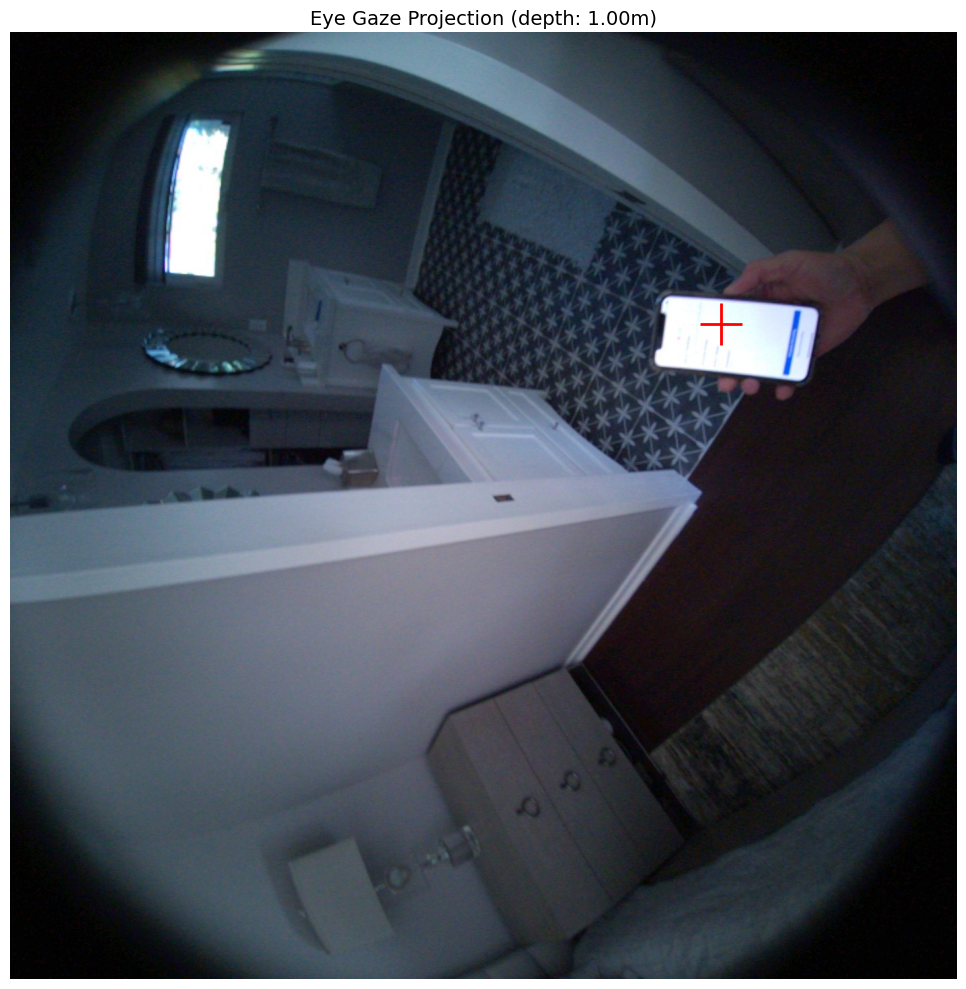

In [10]:
rgb_stream_id = StreamId("214-1")
rgb_stream_label = provider.get_label_from_stream_id(rgb_stream_id)
num_rgb_frames = provider.get_num_data(rgb_stream_id)
rgb_frame = provider.get_image_data_by_index(rgb_stream_id, int(num_rgb_frames - 50))
assert rgb_frame[0] is not None, "no rgb frame"

image = rgb_frame[0].to_numpy_array()
capture_timestamp_ns = rgb_frame[1].capture_timestamp_ns
generalized_eye_gaze = get_nearest_eye_gaze(generalized_eye_gazes, capture_timestamp_ns)

# get projection function
device_calibration = provider.get_device_calibration()
camera_calibration = device_calibration.get_camera_calib(rgb_stream_label)
assert camera_calibration is not None, "no camera calibration"

# Create single subplot (fixed from 1, 1 which caused unpacking error)
fig, ax1 = plt.subplots(1, 1, figsize=(12, 10))

# Draw a cross at the projected gaze center location on the RGB image at available depth or if unavailable a 1m proxy
depth_m = generalized_eye_gaze.depth if generalized_eye_gaze.depth else 1.0
generalized_gaze_center_in_pixels = get_gaze_vector_reprojection(
    generalized_eye_gaze, 
    rgb_stream_label, 
    device_calibration, 
    camera_calibration, 
    depth_m
)

if generalized_gaze_center_in_pixels is not None:
    ax1.imshow(image)
    ax1.plot(
        generalized_gaze_center_in_pixels[0], 
        generalized_gaze_center_in_pixels[1], 
        '+', 
        c="red", 
        mew=2, 
        ms=30
    )
    ax1.grid(False)
    ax1.axis('off')
    ax1.set_title(f"Eye Gaze Projection (depth: {depth_m:.2f}m)", fontsize=14)
else:
    print(f"Eye gaze center is out of camera sensor plane at timestamp {capture_timestamp_ns}")

plt.tight_layout()
plt.show()


In [11]:
gazes = []

num_rgb_frames = provider.get_num_data(rgb_stream_id)
rgb_stream_id = StreamId("214-1")
rgb_stream_label = provider.get_label_from_stream_id(rgb_stream_id)
device_calibration = provider.get_device_calibration()
camera_calibration = device_calibration.get_camera_calib(rgb_stream_label)
   
for i in range(0, 50):
   rgb_frame = provider.get_image_data_by_index(rgb_stream_id, int(num_rgb_frames - 50 + i))

   image = rgb_frame[0].to_numpy_array()
   capture_timestamp_ns = rgb_frame[1].capture_timestamp_ns
   generalized_eye_gaze = get_nearest_eye_gaze(generalized_eye_gazes, capture_timestamp_ns)

   if generalized_eye_gaze is None: continue

   depth_m = generalized_eye_gaze.depth if generalized_eye_gaze.depth else 1.0
   generalized_gaze_center_in_pixels = get_gaze_vector_reprojection(
      generalized_eye_gaze, 
      rgb_stream_label, 
      device_calibration, 
      camera_calibration, 
      depth_m
   )
   x,y = generalized_gaze_center_in_pixels[0], generalized_gaze_center_in_pixels[1]
   gazes.append((x,y))
   

In [12]:
gaze_points = np.array(gazes, dtype=np.float64)
xs = gaze_points[:, 0].astype(int)
ys = gaze_points[:, 1].astype(int)

In [13]:
h, w = image.shape[:2]
heatmap = np.zeros((h, w), dtype=np.float32)

In [14]:
for x, y in zip(xs, ys):
    if 0 <= x < w and 0 <= y < h:
        heatmap[y, x] += 1.0


In [17]:
import cv2
heatmap_blurred = cv2.GaussianBlur(heatmap, (0, 0), sigmaX=25, sigmaY=25)
heatmap_color = cv2.applyColorMap(((heatmap_blurred / heatmap_blurred.max()) * 255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
overlay = (0.5 * image + 0.5 * heatmap_color).astype(np.uint8)

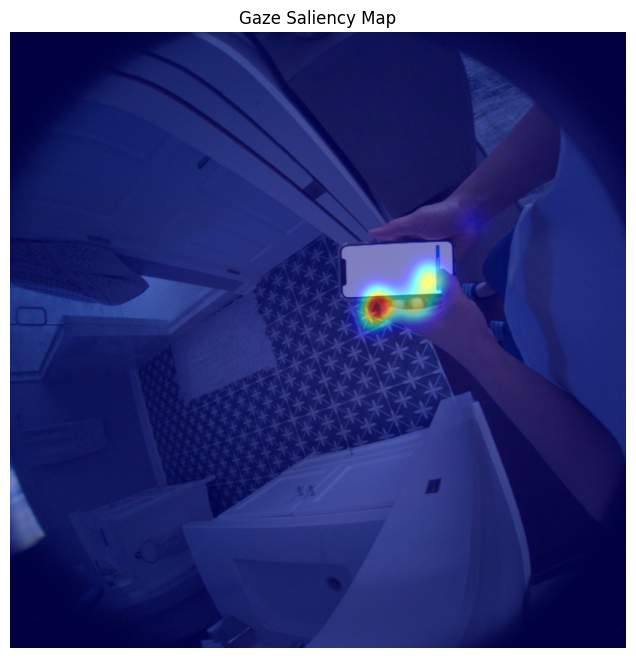

In [18]:
plt.figure(figsize=(10, 8))
plt.imshow(overlay)
plt.axis('off')
plt.title("Gaze Saliency Map")
plt.show()
